# Imports

In [1]:
import string
import numpy as np
import glob
import re
import pickle
from prettytable import PrettyTable
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# File readings

In [3]:
train_negative_path = "Dataset/train/neg/"  # path to positive training reviews
train_positive_path = "Dataset/train/pos/" # path to negative training reviews
test_negative_path = "Dataset/test/neg/"  # path to positive test reviews
test_positive_path = "Dataset/test/pos/" # path to negative test reviews
trainx = [] # list containing train movie reviews
trainy = [] # list containing train labels
testx = [] # list containing test movie reviews
testy = [] # list containing test labels

# function for reading negative and positive reviews into list
def readFiles(path, clas, signal):
    for file in glob.iglob(path + "/" + "*.txt"):
        with open(file, encoding='utf-8') as f:
            data = f.read()
            if signal == "train":
                trainx.append(data)
            else:
                testx.append(data)
            if clas == "neg" and signal == "train":
                trainy.append(0)
            elif clas == "pos" and signal == "train":
                trainy.append(1)
            elif clas == "neg" and signal == "test":
                testy.append(0)
            else:
                testy.append(1)

readFiles(train_negative_path, "neg", "train")
readFiles(train_positive_path, "pos", "train")
readFiles(train_negative_path, "neg", "test")
readFiles(train_positive_path, "pos", "test")

In [4]:
# reading stopwords
stop_words = [] # list containing stop words
stop_words_path = "Dataset/stop_words.txt"  # path to stop words
readingStopWords = open(stop_words_path, 'r')
for word in readingStopWords:
    word = word.strip('\n')
    stop_words.append(word)

In [5]:
# reading negative lexicon
negatives = []
negative_words_path = "Dataset/negative_words.txt"
readingNegativeWords = open(negative_words_path, 'r')
for word in readingNegativeWords:
    word = word.strip('\n')
    negatives.append(word)

In [6]:
# reading positive lexicon
positives = []
positive_words_path = "Dataset/positive_words.txt"
readingPositiveWords = open(positive_words_path, 'r')
for word in readingPositiveWords:
    word = word.strip('\n')
    positives.append(word)

# Preprocessing

In [7]:
# function for preprocessing
def preprocess(signal):
    if signal == "train":
        for i in range(len(trainx)):
            text = trainx[i]

            # lower casing
            text = text.lower()

            # removing stop words
            for word in stop_words:
                text = text.replace(" " + word + " ", " ")

            # removing html characters
            text = re.sub(re.compile('<.*?>'), '', text)

            # removing punctuations
            withoutPunct = ""
            for c in text:
                if c not in string.punctuation:
                    withoutPunct = withoutPunct + c
            text = withoutPunct

            trainx[i] = text
            
    else:
        for i in range(len(testx)):
            text = testx[i]

            # lower casing
            text = text.lower()

            # removing stop words
            for word in stop_words:
                text = text.replace(" " + word + " ", " ")

            # removing html characters
            text = re.sub(re.compile('<.*?>'), '', text)

            # removing punctuations
            withoutPunct = ""
            for c in text:
                if c not in string.punctuation:
                    withoutPunct = withoutPunct + c
            text = withoutPunct

            testx[i] = text

In [8]:
# now preprocessing
preprocess("train")
preprocess("test")

# Feature extraction

In [9]:
# function to extract features
# x0 = bias term = 1
# x1 = count(positives)
# x2 = count(negatives)
# format -> (x0, x1, x2)

features_trainx = []
features_testx = []

def extract_features(signal):
    # features
    x0 = 1
    x1 = None
    x2 = None
    
    if signal == "train":
        for text in trainx:
            text = text.split()

            # calculating feature x1
            vec = []
            for v in positives:
                vec.append(text.count(v))
            x1 = sum(vec)

            # calculating feature x2
            vec = []
            for v in negatives:
                vec.append(text.count(v))
            x2 = sum(vec)

            tuplee = [x0, x1, x2]
            features_trainx.append(tuplee)
            
    else:
        for text in testx:
            text = text.split()

            # calculating feature x1
            vec = []
            for v in positives:
                vec.append(text.count(v))
            x1 = sum(vec)

            # calculating feature x2
            vec = []
            for v in negatives:
                vec.append(text.count(v))
            x2 = sum(vec)

            tuplee = [x0, x1, x2]
            features_testx.append(tuplee)

In [10]:
# now extracting features
# DONT RUN THIS. THIS TAKES AROUND 20 TO 26 MINUTES for both train and test!!
# I saved the features in pickle files so only run the bottom cell to load provided pickle files

# extract_features("train")
# extract_features("test")

In [11]:
# loading from pickle (train features and test features)

features_trainx = None
features_testx = None

with open('featuresTrain.pkl', 'rb') as f:
    features_trainx = pickle.load(f)
    
with open('featuresTest.pkl', 'rb') as f:
    features_testx = pickle.load(f)

In [12]:
trainx = np.array(features_trainx) # converting to numpy lists
trainy = np.array(trainy) # converting to numpy lists
trainx = trainx.T
trainy = trainy.reshape((trainy.size, -1))

testx = np.array(features_testx) # converting to numpy lists
testy = np.array(testy) # converting to numpy lists
testx = testx.T
testy = testy.reshape((testy.size, -1))

In [13]:
print(trainx.shape)
print(trainy.shape)
print('')
print(testx.shape)
print(testy.shape)

(3, 25000)
(25000, 1)

(3, 25000)
(25000, 1)


# Part 1

## Sigmoid function

In [14]:
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

## Hypothesis function

In [15]:
def hyp(theta, x):
    return (np.matmul(theta.T, x))

## Cross entropy loss function

In [16]:
def crossEntropyLoss(x, y, theta):
    m = y.size
    hx = hyp(theta, x)
    sig = sigmoid(hx)
    sig = sig.T
    return (-1 / m) * np.sum(y * np.log2(sig + 1e-10) + (1 - y) * np.log2(1 - sig + 1e-10))

## Batch gradient descent function

In [20]:
def gradientDescent(x, y, n_epoch, alpha):
    print("Running for alpha = ", alpha)
    print('')
    m = y.size # 25000
    J = list() # costs
    theta = np.array([0] * 3)
    theta = theta.reshape((-1, 1))
    for epoch in range(n_epoch):
        sig = sigmoid(hyp(theta, x)).flatten() - y.flatten()
        sig = sig.reshape(m, -1) # shape -> (25000 1)
        lst = []

        for i in range(m):
            lst.append(sig[i] * x.T[i])
            
        summation = np.sum(lst, axis=0)
            
        grad = (1.0 / m) * summation
        grad = grad.reshape((-1, 1))
        temp = theta - alpha * grad
        theta = temp
        
        # computing cross entropy loss
        loss = crossEntropyLoss(x, y, theta)
        J.append(loss)
        
        if (epoch % 100 == 0 and epoch != 0):
            print(epoch, " epochs completed")
            
        if (epoch == 1499):
            print("1500 epochs completed")
            
    print("")
    print("BGD Completed!")
    print("")
    print("Updated parameters")
    print(theta)
    print('')
    print('-----------------------------------------------------------')
    print('')
        
    return theta, J

## Predict function

In [18]:
def predict(theta, x):
    hx = hyp(theta, x)
    sig = sigmoid(hx)
    sig = sig.T
    lst = []
    for i in range(25000):
        if sig[i] >= 0.5:
            lst.append(1)
        else:
            lst.append(0)
    return lst

## Now performing batch gradient descent

In [21]:
# will find optimal value of alpha by running gradient descent on these 9 alpha values
# will then plot graph of costs against iters to visualize results and find best alpha value

alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
costs = []
theetas = []

In [22]:
# This will take around 36 minutes to execute

J = None # costs
theta = None # weights
n_epoch = 1500

for alpha in alphas:
    theta, J = gradientDescent(trainx, trainy, n_epoch, alpha)
    theetas.append(theta)
    costs.append(J)

Running for alpha =  0.01

100  epochs completed
200  epochs completed
300  epochs completed
400  epochs completed
500  epochs completed
600  epochs completed
700  epochs completed
800  epochs completed
900  epochs completed
1000  epochs completed
1100  epochs completed
1200  epochs completed
1300  epochs completed
1400  epochs completed
1500 epochs completed

BGD Completed!

Updated parameters
[[-0.16846414]
 [ 0.19533985]
 [-0.1844968 ]]

-----------------------------------------------------------

Running for alpha =  0.02

100  epochs completed
200  epochs completed
300  epochs completed
400  epochs completed
500  epochs completed
600  epochs completed
700  epochs completed
800  epochs completed
900  epochs completed
1000  epochs completed
1100  epochs completed
1200  epochs completed
1300  epochs completed
1400  epochs completed
1500 epochs completed

BGD Completed!

Updated parameters
[[-0.23525325]
 [ 0.19916142]
 [-0.18302543]]

-------------------------------------------------

## Plotting loss against epochs to determine best alpha value

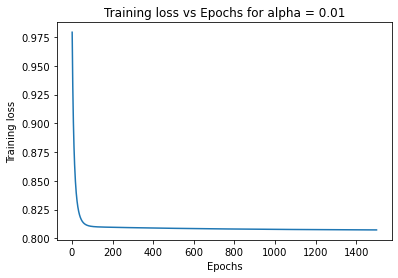

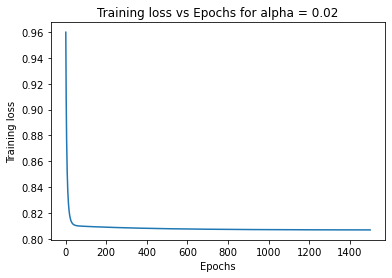

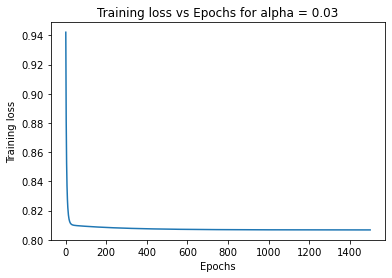

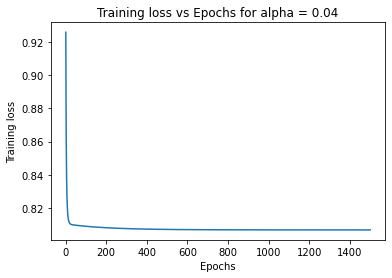

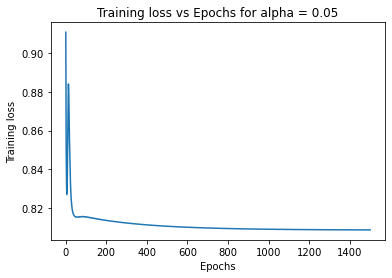

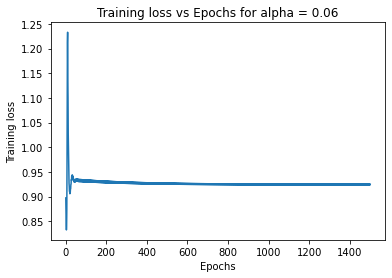

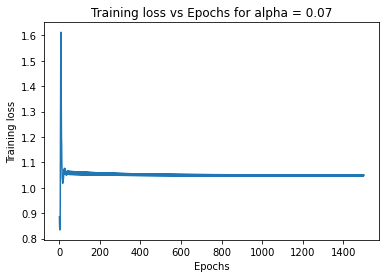

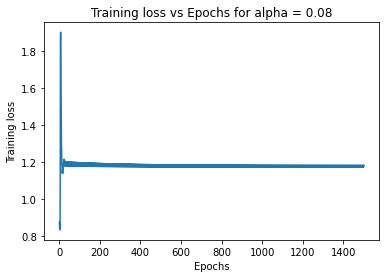

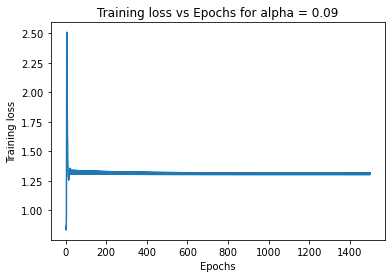

In [35]:
iters = [i for i in range(1, n_epoch + 1, 1)]
for i in range(len(alphas)):
    plt.plot(iters, costs[i])
    plt.xlabel('Epochs')
    plt.ylabel('Training loss')
    plt.title("Training loss vs Epochs for alpha = " + str(alphas[i]))
    plt.show()

### Hence, best alpha value is 0.01

## Now predicting for test data

In [38]:
pred = predict(theetas[0], testx)

## Evaluating on test data

In [39]:
acc = 0
for i in range(25000):
    if pred[i] == testy[i]:
        acc = acc + 1
        
acc = acc / 25000

acc = acc * 100

print("Accuracy on test set: ", acc, "%")

Accuracy on test set:  72.956 %


## Confusion matrix on test set

In [40]:
pp = 0 # true positives
pn = 0 # false negatives
np = 0 # false positives
nn = 0 # true negatives

for i in range(25000):
    if testy[i] == 1 and pred[i] == 1:
        pp = pp + 1
    elif testy[i] == 1 and pred[i] == 0:
        pn = pn + 1
    elif testy[i] == 0 and pred[i] == 1:
        np = np + 1
    elif testy[i] == 0 and pred[i] == 0:
        nn = nn + 1

mat = PrettyTable()
mat.field_names = ["-", "positive", "negative"]
mat.add_row(["positive", pp, pn])
mat.add_row(["negative", np, nn])

print("Confusion Matrix")
print("")
print(mat)

Confusion Matrix

+----------+----------+----------+
|    -     | positive | negative |
+----------+----------+----------+
| positive |   9338   |   3162   |
| negative |   3599   |   8901   |
+----------+----------+----------+


## Now plotting training loss against epochs for best alpha value

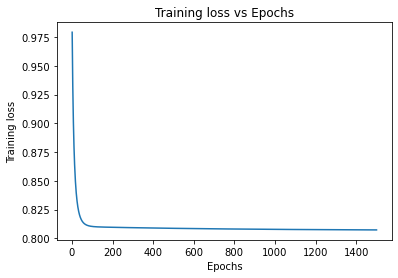

In [41]:
# best alpha value came out to be 0.01 as shown above

iters = [i for i in range(1, n_epoch + 1, 1)]
plt.plot(iters, costs[0])
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title("Training loss vs Epochs")
plt.show()

# Part 2

In [204]:
clf = LogisticRegression(random_state=0).fit(trainx.T, trainy)

C:\Users\gs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [205]:
pred = clf.predict(testx.T)
pred

array([0, 0, 1, ..., 0, 1, 1])

In [206]:
clf.predict_proba(testx.T)

array([[0.67407977, 0.32592023],
       [0.95033673, 0.04966327],
       [0.35277651, 0.64722349],
       ...,
       [0.81769894, 0.18230106],
       [0.32082625, 0.67917375],
       [0.25937941, 0.74062059]])

In [207]:
print("Score: ", clf.score(trainx.T, trainy))

Score:  0.7254


In [210]:
print("Accuracy on test set: ", accuracy_score(testy, pred) * 100, "%")

Accuracy on test set:  72.54 %


In [211]:
print("Confusion matrix")
print("")
confusion_matrix(testy, pred)

Confusion matrix



array([[9070, 3430],
       [3435, 9065]], dtype=int64)